In [7]:
%matplotlib inline
import findspark
findspark.init()
import mysql.connector
import matplotlib.pyplot as plt
import seaborn
import requests

from pyspark.sql import SparkSession
from pyspark.sql.functions import*

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DoubleType

import pandas as pd
import datetime


spark = SparkSession.builder.master("local[*]").appName("Capstone").getOrCreate()

CDW_SAPP_CUSTMER.JSON extracted and transformed 

In [8]:
# Load the JSON file into a PySpark SQL dataframe
credit_cards_df = spark.read.json("json_files\cdw_sapp_custmer.json")

# Add "678" at the beginning of the phone number
new_phone_number = concat(lit("678"), col("CUST_PHONE"))

# Format the phone number into (XXX)XXX-XXXX format
formatted_phone_number = concat(lit("("), substring(new_phone_number, 1, 3), lit(")"),
                        substring(new_phone_number, 4, 3), lit("-"),
                        substring(new_phone_number, 7, 4))

#adds the new number to credit_cards
credit_cards_df = credit_cards_df.withColumn("FORMATTED_PHONE_NUMBER", formatted_phone_number)

# Select the required fields from the dataframe and transform data
CDW_SAPP_CUSTOMER = credit_cards_df.select("SSN",
                                        initcap("FIRST_NAME").alias("FIRST_NAME"),
                                        lower("MIDDLE_NAME").alias("MIDDLE_NAME"),
                                        initcap("LAST_NAME").alias("LAST_NAME"), 
                                        "Credit_card_no",
                                        concat( "APT_NO", lit(", "), "STREET_NAME").alias("ADDRESS"),
                                        "CUST_CITY", "CUST_STATE", "CUST_COUNTRY", "CUST_ZIP",
                                        "CUST_EMAIL","FORMATTED_PHONE_NUMBER", "LAST_UPDATED")

CDW_SAPP_CUSTOMER.show(1)


+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------------+----------------------+--------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  Credit_card_no|             ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|         CUST_EMAIL|FORMATTED_PHONE_NUMBER|        LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------------+----------------------+--------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|656, Main Street ...|  Natchez|        MS|United States|   39120|AHooper@example.com|         (678)123-7818|2018-04-21T12:49:...|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+-------------------+----------------------+--------------------+
only showing top 1 row



CDW_SAPP_CREDIT.JSON extracted and transformed 

In [20]:
# Load the JSON file into a PySpark SQL dataframe
credit_cards_df2 = spark.read.json("json_files\cdw_sapp_credit.json")

# Convert DAY, MONTH, YEAR to TIMEID in YYYYMMDD format
timeid = concat(col("YEAR"), lpad(col("MONTH"), 2, "0"), lpad(col("DAY"), 2, "0"))
credit_cards_df2 = credit_cards_df2.withColumn("TIMEID", timeid)

# Select the required fields from the dataframe and transform data
CDW_SAPP_CREDIT = credit_cards_df2.select("CREDIT_CARD_NO", "TIMEID", "CUST_SSN", "BRANCH_CODE",
                                          "TRANSACTION_TYPE", "TRANSACTION_VALUE", "TRANSACTION_ID")

CDW_SAPP_CREDIT.show()


+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|  CREDIT_CARD_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1|
|4210653349028689|20180320|123459988|         35|   Entertainment|            14.24|             2|
|4210653349028689|20180708|123459988|        160|         Grocery|             56.7|             3|
|4210653349028689|20180419|123459988|        114|   Entertainment|            59.73|             4|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|
|4210653349028689|20180528|123459988|        164|       Education|             6.89|             6|
|4210653349028689|20180519|123459988|        119|   Entertainment|            43.39|             7|


CDW_SAPP_BRANCH.JSON extracted and transformed 

In [23]:
# Load the JSON file into a PySpark SQL dataframe
credit_cards_df3 = spark.read.json("json_files\cdw_sapp_branch.json")

# Add "678" at the beginning of the phone number
new_phone_number2 = col("BRANCH_PHONE")

# Format the phone number into (XXX)XXX-XXXX format
formatted_phone_number2 = concat(lit("("), substring(new_phone_number2, 1, 3), lit(")"),
                        substring(new_phone_number2, 4, 3), lit("-"),
                        substring(new_phone_number2, 7, 4))

#adds the new number to credit_cards
credit_cards_df3 = credit_cards_df3.withColumn("BRANCH_PHONE", formatted_phone_number2)

# Add a new column 'BRANCH_ZIP_NEW' based on the value of 'BRANCH_ZIP'
credit_cards_df3 = credit_cards_df3.withColumn(
    "BRANCH_ZIP_NEW",
    when(col("BRANCH_ZIP").isNull(), "00000").otherwise(col("BRANCH_ZIP"))
)

# Select the required fields from the dataframe and transform data
CDW_SAPP_BRANCH = credit_cards_df3.select("BRANCH_CODE","BRANCH_NAME","BRANCH_STREET",
                                          "BRANCH_CITY","BRANCH_STATE","BRANCH_ZIP_NEW",
                                          "BRANCH_PHONE","LAST_UPDATED")

CDW_SAPP_BRANCH.show()

+-----------+------------+-------------------+-----------------+------------+--------------+-------------+--------------------+
|BRANCH_CODE| BRANCH_NAME|      BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP_NEW| BRANCH_PHONE|        LAST_UPDATED|
+-----------+------------+-------------------+-----------------+------------+--------------+-------------+--------------------+
|          1|Example Bank|       Bridle Court|        Lakeville|          MN|         55044|(123)456-5276|2018-04-18T16:51:...|
|          2|Example Bank|  Washington Street|          Huntley|          IL|         60142|(123)461-8993|2018-04-18T16:51:...|
|          3|Example Bank|      Warren Street|SouthRichmondHill|          NY|         11419|(123)498-5926|2018-04-18T16:51:...|
|          4|Example Bank|   Cleveland Street|       Middleburg|          FL|         32068|(123)466-3064|2018-04-18T16:51:...|
|          5|Example Bank|        14th Street|    KingOfPrussia|          PA|         19406|(123)484-970

load CDW_SAPP_CUSTOMER into the creditcard_capstone MariaDB database 

In [ ]:
CDW_SAPP_CUSTOMER.write.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                user="root",\
                                password="password",\
                                url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                                dbtable="creditcard_capstone.CDW_SAPP_CUSTOMER").save()


load CDW_SAPP_BRANCH into the creditcard_capstone MariaDB database 

In [ ]:
CDW_SAPP_BRANCH.write.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                user="root",\
                                password="password",\
                                url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                                dbtable="creditcard_capstone.CDW_SAPP_BRANCH").save()


load CDW_SAPP_CREDIT into the creditcard_capstone MariaDB database 

In [ ]:
CDW_SAPP_CREDIT.write.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                user="root",\
                                password="password",\
                                url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                                dbtable="creditcard_capstone.CDW_SAPP_CREDIT").save()


connecting to the DB and creating a cursor

In [56]:
# Establish a connection to the database
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="password",
  database="creditcard_capstone"
)

# Create a cursor object to execute SQL queries
mycursor = mydb.cursor()


Display transactions made by customers living in a given zip code for a given month and year, Order by day in descending order.


In [58]:
def transactions_zip_month_year(zip_code, month, year):
    # format the month and year parameters as a string in the format "YYYYMM"
    timeid = year + month
    
    sql = "SELECT CDW_SAPP_CREDIT.CREDIT_CARD_NO, CDW_SAPP_CREDIT.TIMEID, CDW_SAPP_CREDIT.TRANSACTION_TYPE, CDW_SAPP_CREDIT.TRANSACTION_VALUE \
    FROM CDW_SAPP_CREDIT \
    JOIN CDW_SAPP_CUSTOMER ON CDW_SAPP_CREDIT.CUST_SSN = CDW_SAPP_CUSTOMER.SSN \
    WHERE CDW_SAPP_CUSTOMER.CUST_ZIP = %s AND CDW_SAPP_CREDIT.TIMEID LIKE %s \
    ORDER BY CDW_SAPP_CREDIT.TIMEID DESC"
    
    val = (zip_code, f"{timeid}%")
    mycursor.execute(sql, val)
    result = mycursor.fetchall()
    for row in result:
        print(row)


transactions_zip_month_year("30096", "08", "2018")



('4210653338154903', '20180828', 'Gas', 50.97)
('4210653338154903', '20180827', 'Gas', 32.05)
('4210653382641045', '20180827', 'Bills', 1.14)
('4210653382641045', '20180826', 'Healthcare', 31.0)
('4210653399732638', '20180826', 'Grocery', 90.23)
('4210653338154903', '20180825', 'Test', 51.48)
('4210653338154903', '20180823', 'Healthcare', 41.65)
('4210653382641045', '20180823', 'Bills', 21.11)
('4210653338154903', '20180822', 'Bills', 88.11)
('4210653399732638', '20180822', 'Test', 51.3)
('4210653399732638', '20180822', 'Test', 28.62)
('4210653338154903', '20180821', 'Grocery', 91.99)
('4210653356095097', '20180821', 'Test', 63.58)
('4210653323924048', '20180820', 'Education', 28.05)
('4210653323924048', '20180820', 'Healthcare', 71.18)
('4210653323924048', '20180819', 'Healthcare', 19.33)
('4210653338154903', '20180817', 'Entertainment', 33.17)
('4210653338154903', '20180816', 'Entertainment', 20.86)
('4210653338154903', '20180815', 'Test', 63.21)
('4210653382641045', '20180814', 'Edu

Display the number and total values of transactions for a given type

In [59]:
def transactions_by_type(transaction_type):
    sql = "SELECT COUNT(*), SUM(TRANSACTION_VALUE) FROM CDW_SAPP_CREDIT \
           WHERE TRANSACTION_TYPE = %s"
    val = (transaction_type,)
    mycursor.execute(sql, val)
    result = mycursor.fetchone()
    print("Number of transactions for type", transaction_type, "is", result[0])
    print("Total value of transactions for type", transaction_type, "is", result[1])

transactions_by_type("Entertainment")

Number of transactions for type Entertainment is 6635
Total value of transactions for type Entertainment is 338950.09999999945


Display the number and total values of transactions for branches in a given state

In [61]:
def transactions_by_state(state):
    sql = "SELECT COUNT(*), SUM(TRANSACTION_VALUE) FROM CDW_SAPP_CREDIT \
           JOIN CDW_SAPP_BRANCH ON CDW_SAPP_CREDIT.BRANCH_CODE = CDW_SAPP_BRANCH.BRANCH_CODE \
           WHERE CDW_SAPP_BRANCH.BRANCH_STATE = %s"
    val = (state,)
    mycursor.execute(sql, val)
    result = mycursor.fetchone()
    print("Number of transactions for branches in state", state, "is", result[0])
    print("Total value of transactions for branches in state", state, "is", result[1])

transactions_by_state("GA")

Number of transactions for branches in state GA is 2023
Total value of transactions for branches in state GA is 102716.99000000008


Check the existing account details of a customer.


In [57]:
def customer_account_info(credit_card_no):

    sql = "SELECT CDW_SAPP_BRANCH.BRANCH_NAME, CDW_SAPP_CUSTOMER.FIRST_NAME, CDW_SAPP_CUSTOMER.LAST_NAME, CDW_SAPP_CUSTOMER.ADDRESS, CDW_SAPP_CUSTOMER.CUST_CITY, CDW_SAPP_CUSTOMER.CUST_STATE, CDW_SAPP_CUSTOMER.CUST_ZIP, CDW_SAPP_CREDIT.CREDIT_CARD_NO, CDW_SAPP_CREDIT.CUST_SSN \
    FROM CDW_SAPP_CREDIT \
    JOIN CDW_SAPP_CUSTOMER ON CDW_SAPP_CREDIT.CUST_SSN = CDW_SAPP_CUSTOMER.SSN \
    JOIN CDW_SAPP_BRANCH ON CDW_SAPP_CREDIT.BRANCH_CODE = CDW_SAPP_BRANCH.BRANCH_CODE \
    WHERE CDW_SAPP_CREDIT.CREDIT_CARD_NO = %s \
    GROUP BY CDW_SAPP_CREDIT.CREDIT_CARD_NO"
    val = (credit_card_no,)
    mycursor.execute(sql, val)
    result = mycursor.fetchall()
    for row in result:
        print(row)

customer_account_info("4210653349028689")

('Example Bank', 'Amalia', 'Campos', '774, Valley Drive', 'Harleysville', 'PA', '19438', '4210653349028689', 123459988)


Modify the existing account details of a customer.


In [75]:
def modify_customer_account_details(SSN, new_address, new_city, new_state, new_zip):
    sql = "UPDATE CDW_SAPP_CUSTOMER \
           SET ADDRESS = %s, CUST_CITY = %s, CUST_STATE = %s, CUST_ZIP = %s \
           WHERE SSN = %s"
    val = (new_address, new_city, new_state, new_zip, SSN)
    mycursor.execute(sql, val)
    mydb.commit()
    print(mycursor.rowcount, "record(s) affected")


Generate a monthly bill for a credit card number for a given month and year.


In [77]:
def generate_monthly_bill(credit_card_no, month, year):
    # format the month and year parameters as a string in the format "YYYYMM"
    timeid = year + month
    
    # query to calculate the monthly bill
    sql = "SELECT TRANSACTION_TYPE, SUM(TRANSACTION_VALUE) AS TOTAL_SPEND FROM CDW_SAPP_CREDIT \
           WHERE CREDIT_CARD_NO = %s AND TIMEID LIKE %s \
           GROUP BY TRANSACTION_TYPE"
    
    # execute the query
    val = (credit_card_no, f"{timeid}%")
    mycursor.execute(sql, val)
    result = mycursor.fetchall()
    
    # calculate the total bill amount
    total_bill = 0
    for row in result:
        if row[0] == "C":
            total_bill -= row[1]
        else:
            total_bill += row[1]
    
    # print the bill information
    print("Credit card number:", credit_card_no)
    print("Billing period:", month, "/", year)
    print("Total amount due:", total_bill)


generate_monthly_bill("4210653312837854", "09", "2018")

Credit card number: 4210653312837854
Billing period: 09 / 2018
Total amount due: 643.23


Display the transactions made by a customer between two dates. Order by year, month, and day in descending order.

In [16]:
def transactions_by_date_range(SSN, start_timeid, end_timeid):
    mycursor = mydb.cursor()
    sql = """
        SELECT SUBSTR(CDW_SAPP_CREDIT.TIMEID, 1, 4) AS YEAR, SUBSTR(CDW_SAPP_CREDIT.TIMEID, 5, 2) AS MONTH, 
               SUBSTR(CDW_SAPP_CREDIT.TIMEID, 7, 2) AS DAY, CDW_SAPP_CREDIT.TRANSACTION_TYPE
        FROM CDW_SAPP_CREDIT
        JOIN CDW_SAPP_CUSTOMER ON CDW_SAPP_CREDIT.CUST_SSN = CDW_SAPP_CUSTOMER.SSN
        WHERE CDW_SAPP_CREDIT.CUST_SSN = %s 
          AND CDW_SAPP_CREDIT.TIMEID >= %s 
          AND CDW_SAPP_CREDIT.TIMEID <= %s 
        ORDER BY YEAR DESC, MONTH DESC, DAY DESC
    """
    val = (SSN, start_timeid, end_timeid)
    mycursor.execute(sql, val)
    result = mycursor.fetchall()
    for row in result:
        print(row)



start_timeid = '20180101'
end_timeid = '20180131'
transactions_by_date_range('123456100', start_timeid, end_timeid)


('2018', '01', '26', 'Education')
('2018', '01', '13', 'Entertainment')
('2018', '01', '13', 'Entertainment')


DATA VISUALIZTION

Find and plot which transaction type has a high rate of transactions.

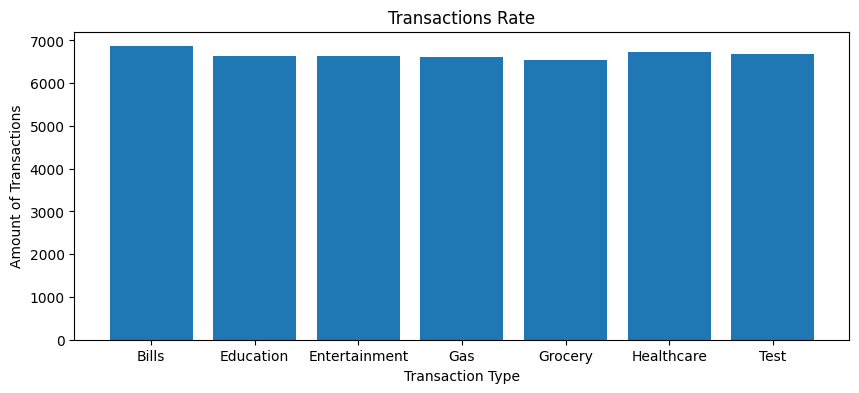

In [46]:
%matplotlib inline
import mysql.connector
import matplotlib.pyplot as plt


mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="creditcard_capstone"
)
mycursor = mydb.cursor()

# Write the SQL query to get the count of each transaction type
sql = "SELECT TRANSACTION_TYPE, COUNT(*) AS COUNT FROM CDW_SAPP_CREDIT\
        GROUP BY TRANSACTION_TYPE"

# Execute the query and fetch the results
mycursor.execute(sql)
result = mycursor.fetchall()

# Extract the transaction types and their counts into separate lists
transaction_types = [row[0] for row in result]
counts = [row[1] for row in result]

# Create a bar chart showing the count of each transaction type
fig, ax = plt.subplots(figsize=(10,4))
plt.bar(transaction_types, counts)
plt.xlabel('Transaction Type')
plt.ylabel('Amount of Transactions')
plt.title('Transactions Rate')


plt.show()


Find and plot which state has a high number of customers

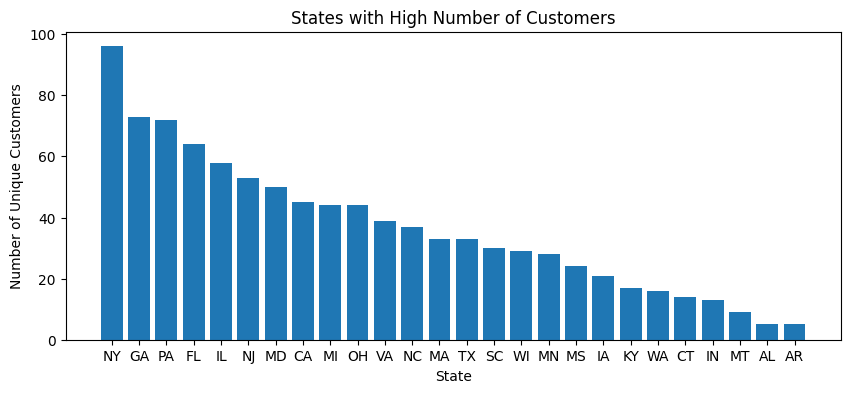

In [40]:
%matplotlib inline
import mysql.connector
import matplotlib.pyplot as plt

# Connect to the database
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="creditcard_capstone"
)

# Execute the SQL query to count the number of unique customers in each state
mycursor = mydb.cursor()
sql = "SELECT UPPER(CUST_STATE), COUNT(DISTINCT SSN) AS COUNT FROM CDW_SAPP_CUSTOMER \
        GROUP BY UPPER(CUST_STATE) ORDER BY COUNT DESC"
mycursor.execute(sql)
result = mycursor.fetchall()

# Extract the states and their counts into separate lists
states = [row[0] for row in result]
counts = [row[1] for row in result]

# Create a bar chart showing the number of unique customers in each state
fig, ax = plt.subplots(figsize=(10,4))
plt.bar(states, counts)
plt.xlabel('State')
plt.ylabel('Number of Unique Customers')
plt.title('States with High Number of Customers')
plt.show()

# Close the database connection
mydb.close()


Find and plot the sum of all transactions for the top 10 customers, and which customer has the highest transaction amount.

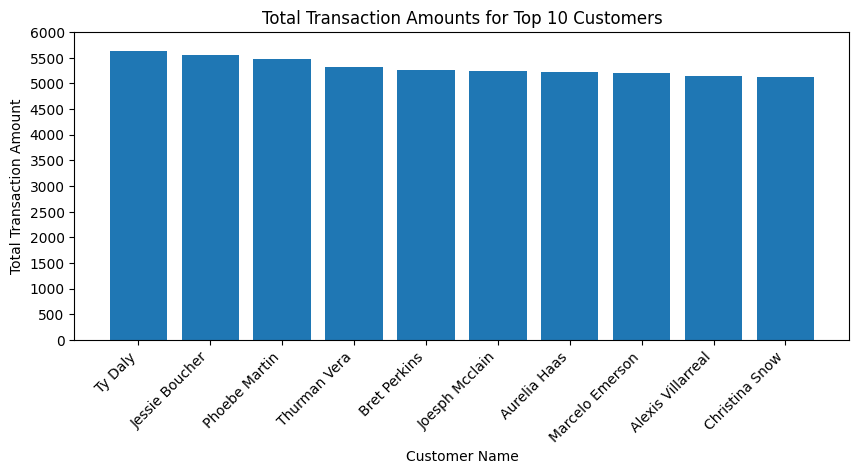

In [47]:
%matplotlib inline
import mysql.connector
import matplotlib.pyplot as plt


# Connect to the database
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="password",
    database="creditcard_capstone"
)

# Execute the SQL query to get the total transaction amounts for the top 10 customers
mycursor = mydb.cursor()
sql = "SELECT CONCAT(FIRST_NAME, ' ', LAST_NAME) AS NAME, SUM(TRANSACTION_VALUE) AS TOTAL FROM CDW_SAPP_CREDIT \
        JOIN CDW_SAPP_CUSTOMER ON CDW_SAPP_CREDIT.CUST_SSN = CDW_SAPP_CUSTOMER.SSN \
            GROUP BY CUST_SSN ORDER BY TOTAL DESC LIMIT 10"

mycursor.execute(sql)
result = mycursor.fetchall()

# Extract the customer names and their total transaction amounts into separate lists
customers = [row[0] for row in result]
totals = [row[1] for row in result]

# Create a bar chart showing the total transaction amounts for the top 10 customers
fig, ax = plt.subplots(figsize=(10,4))
plt.bar(customers, totals)
plt.xlabel('Customer Name')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amounts for Top 10 Customers')
plt.xticks(range(len(customers)), customers, rotation=45, ha='right')
plt.yticks(range(0, int(max(totals))+500, 500))

plt.show()

# Close the database connection
mydb.close()



LOAN Application Dataset

In [3]:
# Create a Python program to GET (consume) data from the above API endpoint for the loan application dataset.
url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"

response = requests.get(url)

#Find the status code of the above API endpoint.
if response.status_code == 200:
    loan_data = response.json()
    print("Successfully retrieved loan data from API.")
else:
    print("Error retrieving loan data from API. Status code:", response.status_code)


Successfully retrieved loan data from API.


Loaded API data into creditcard_capstone Database

In [21]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import col

# Read the loan data from the API using Pandas
loan_data = pd.read_json("https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json")

# Convert the Credit_History column to float
loan_data['Credit_History'] = loan_data['Credit_History'].astype(float)

# Define the schema for the loan data
loan_data_schema = StructType([
    StructField("Application_ID", StringType(), True),
    StructField("Gender", StringType(), True),
    StructField("Married", StringType(), True),
    StructField("Dependents", StringType(), True),
    StructField("Education", StringType(), True),
    StructField("Self_Employed", StringType(), True),
    StructField("Credit_History", FloatType(), True),
    StructField("Property_Area", StringType(), True),
    StructField("Income", StringType(), True),
    StructField("Application_Status", StringType(), True)
])

# Create a SparkSession
spark = SparkSession.builder.appName("Pandas to Spark to SQL").getOrCreate()

# Create a PySpark DataFrame from the Pandas DataFrame
spark_df = spark.createDataFrame(loan_data, schema=loan_data_schema)

# Define the MySQL connection properties
mysql_url = "jdbc:mysql://localhost:3306/creditcard_capstone"
mysql_table = "CDW_SAPP_loan_application"
mysql_props = {
    "user": "root",
    "password": "password",
    "driver": "com.mysql.cj.jdbc.Driver"
}

# Write the loan data to the MySQL table
spark_df.write.jdbc(url=mysql_url, table=mysql_table, mode="overwrite", properties=mysql_props)

# Close the Spark session
spark.stop()


Find and plot the amount of applications approved for self-employed applicants.

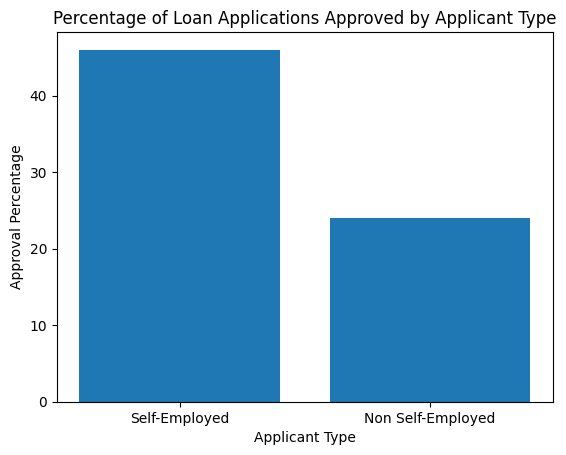

Amount of approved applications for self employed applicants: 46
Number of rejected applications for self employed applicants: 24


In [101]:
import mysql.connector
import matplotlib.pyplot as plt

# establish a connection to the MySQL database
sql = mysql.connector.connect(user='root', password='password', host='localhost', database='creditcard_capstone')

# execute a SELECT query to retrieve the loan data from the table
cursor = sql.cursor()
query = "SELECT * FROM CDW_SAPP_loan_application"
cursor.execute(query)

# initialize counters for approved and rejected applications for self-employed and non self-employed applicants
self_employed_approved = 0
self_employed_rejected = 0


# iterate through the query results
for row in cursor.fetchall():
    # increment the appropriate counter based on whether the applicant is self-employed and whether their application was approved
    if row[5] == 'Yes':
        if row[9] == 'Y':
            self_employed_approved += 1
        else:
            self_employed_rejected += 1


# create a bar chart of the percentage of applications approved for self-employed and non self-employed applicants
fig, ax = plt.subplots()
ax.bar(['Self-Employed', 'Non Self-Employed'],[self_employed_approved, self_employed_rejected])
ax.set_xlabel('Applicant Type')
ax.set_ylabel('Approval Percentage')
ax.set_title('Percentage of Loan Applications Approved by Applicant Type')
plt.show()


print("Amount of approved applications for self employed applicants: {}".format(self_employed_approved))
print("Number of rejected applications for self employed applicants: {}".format(self_employed_rejected))

Find the amount of rejection for married male applicants.

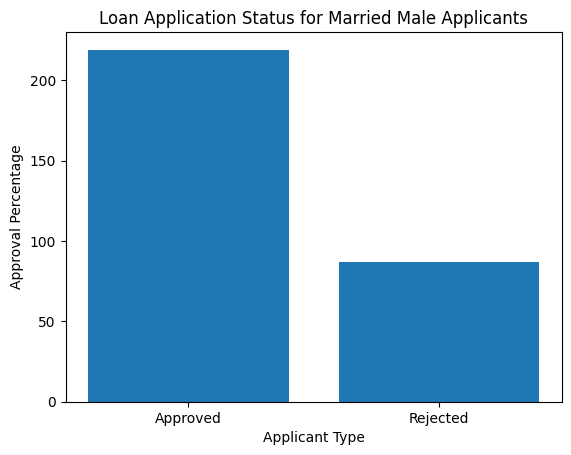

Percentage of approved applications for married male applicants: 219
Number of rejected applications for married male applicants: 87


In [105]:
import mysql.connector
import matplotlib.pyplot as plt

# establish a connection to the MySQL database
sql = mysql.connector.connect(user='root', password='password', host='localhost', database='creditcard_capstone')

# execute a SELECT query to retrieve the loan data from the table
cursor = sql.cursor()
query = "SELECT * FROM CDW_SAPP_loan_application"
cursor.execute(query)

# initialize counters for approved and rejected applications for married male applicants
married_male_approved = 0
married_male_rejected = 0

# iterate through the query results
for row in cursor.fetchall():
    # increment the appropriate counter based on whether the applicant is a married male and whether their application was approved
    if row[1] == 'Male' and row[2] == 'Yes':
        if row[9] == 'Y':
            married_male_approved += 1
        else:
            married_male_rejected += 1


fig, ax = plt.subplots()
ax.bar(['Approved', 'Rejected'],[married_male_approved, married_male_rejected])
ax.set_xlabel('Applicant Type')
ax.set_ylabel('Approval Percentage')
ax.set_title('Loan Application Status for Married Male Applicants')
plt.show()

# output the results
print("Percentage of approved applications for married male applicants: {}".format(married_male_approved))
print("Number of rejected applications for married male applicants: {}".format(married_male_rejected))

